In [1]:
# Montar o google drive no coolab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Bibliotecas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import Counter
from itertools import chain

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from transformers import BertTokenizer, RobertaTokenizer, BertTokenizerFast, BertModel, BertForSequenceClassification
import torch
import torch.nn.functional as F
import torch.nn as nn

from sklearn.metrics import classification_report
from sklearn import metrics

import pickle
import re
import os
from tqdm import tqdm
import ast
import random
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, Dataset


## Importando DataFrames

In [3]:
df_test_GPTrelev = pd.read_pickle('/content/drive/MyDrive/Mestrado/Dissertação/Experimentos/anxiety/01. data/03. prediction/prediction_GPTrelev_MinTL.pkl')
df_test_w2vreglog = pd.read_pickle('/content/drive/MyDrive/Mestrado/Dissertação/Experimentos/anxiety/01. data/03. prediction/prediction_w2vreglog_MinTL.pkl')
df_test_softbert = pd.read_pickle('/content/drive/MyDrive/Mestrado/Dissertação/Experimentos/anxiety/01. data/03. prediction/prediction_softBERT_MinTL.pkl')

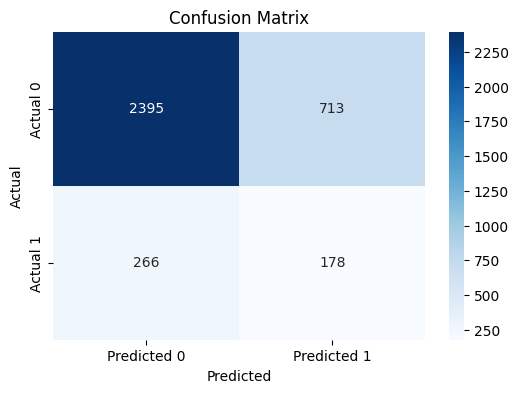

In [4]:
# Confusion matrix
cm = confusion_matrix(df_test_GPTrelev['Numeric_Diagnosed_YN'], df_test_GPTrelev['predict_Diagnosed_YN'])

# Exibindo a matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [5]:
# Renomear colunas no df_test_GPTrelev
df_test_GPTrelev = df_test_GPTrelev.rename(columns={'predict_Diagnosed_YN': 'predict_GPTrelev', 'qt_msgs_lidas': 'qtd_msgs_lidas_GPTrelev'})

# Renomear colunas no df_test_w2vreglog
df_test_w2vreglog = df_test_w2vreglog.rename(columns={'prediction': 'predict_w2vreglog', 'qtd_msgs_lidas': 'qtd_msgs_lidas_w2vreglog'})

# Renomear colunas no df_test_softbert
df_test_softbert = df_test_softbert.rename(columns={'prediction': 'predict_softbert', 'qtd_msgs_lidas': 'qtd_msgs_lidas_softbert'})

In [6]:
# Unir df_test_w2vreglog e df_test_softbert
df_merged = pd.merge(df_test_w2vreglog[['User_ID', 'Diagnosed_YN', 'predict_w2vreglog', 'qtd_msgs_lidas_w2vreglog']],
                     df_test_softbert[['User_ID', 'predict_softbert', 'qtd_msgs_lidas_softbert']],
                     on='User_ID',
                     how='inner')

# Unir o resultado com df_test_GPTrelev
df_final = pd.merge(df_merged,
                    df_test_GPTrelev[['User_ID', 'label_min', 'predict_GPTrelev', 'qtd_msgs_lidas_GPTrelev']],
                    on='User_ID',
                    how='inner')


In [7]:
df_final['Erro_w2vreglog'] = (df_final['predict_w2vreglog'] != df_final['Diagnosed_YN']).astype(int)
df_final['Erro_softbert'] = (df_final['predict_softbert'] != df_final['Diagnosed_YN']).astype(int)
df_final['Erro_GPTrelev'] = (df_final['predict_GPTrelev'] != df_final['Diagnosed_YN']).astype(int)

In [8]:
df_final.to_pickle('/content/drive/MyDrive/Mestrado/Dissertação/Experimentos/anxiety/01. data/02. clean/analise_erro.pkl')
# df_final = pd.read_pickle('/content/drive/MyDrive/Mestrado/Dissertação/Experimentos/anxiety/01. data/02. clean/analise_erro.pkl')
df_final.head()

,User_ID,Diagnosed_YN,predict_w2vreglog,qtd_msgs_lidas_w2vreglog,predict_softbert,qtd_msgs_lidas_softbert,label_min,predict_GPTrelev,qtd_msgs_lidas_GPTrelev,Erro_w2vreglog,Erro_softbert,Erro_GPTrelev
0,A_1857,1,0,2133,0,2133,"[3, 6, 0, 0, 1, 1, 2, 1, 2, 1, 0, 2, 6, 6, 3, ...",1,74,1,1,0
1,A_1867,1,0,1081,0,1081,"[2, 2, 6, 2, 2, 3, 2, 3, 1, 3, 0, 2, 3, 0, 2, ...",0,89,1,1,1
2,A_414,1,0,1596,0,1596,"[1, 0, 1, 6, 2, 3, 0, 0, 6, 0, 1, 3, 2, 2, 6, ...",0,89,1,1,1
3,A_486,1,0,957,0,957,"[0, 1, 0, 0, 1, 1, 1, 1, 2, 0, 6, 1, 1, 1, 3, ...",0,89,1,1,1
4,A_644,1,0,103,0,103,"[1, 1, 2, 1, 1, 0, 3, 6, 2, 6, 1, 7, 0, 6, 3, ...",0,89,1,1,1


## Análise de erros

1. Selecionar aleatoriamente N instâncias de teste positivas e N negativas que tenham sido incorretamente classificadas; se possível, considere N como o nro total de instâncias positivas incorretas do conjunto de teste
2. Registrar a quantidade (%) dessas instâncias que o baseline errou também, e descartar
3. Considerando apenas o restante, ou seja, instâncias que o GPTrelev classificou errado e o baseline certo

In [9]:
df_final.value_counts('predict_GPTrelev', dropna=False)

,count
predict_GPTrelev,
0,2661
1,891


In [10]:
df_final.value_counts('Diagnosed_YN', dropna=False)

,count
Diagnosed_YN,
0,3108
1,444


In [11]:
# selecionar aleatoriamente N instâncias positivas e N negativas que tenham sido incorretamente classificadas
# N = total de instâncias positivas incorretas

qtd_positivas = len(df_final[(df_final['predict_GPTrelev'] == 0) & (df_final['Diagnosed_YN'] == 1)]) # instâncias positivas classificadas incorretamente
qtd_negativas = len(df_final[(df_final['predict_GPTrelev'] == 1) & (df_final['Diagnosed_YN'] == 0)]) # instâncias negativas classificadas incorretamente

print(f'Quantidade de instâncias positivas classificadas incorretamente: {qtd_positivas}')
print(f'Quantidade de instâncias negativas classificadas incorretamente: {qtd_negativas}')

Quantidade de instâncias positivas classificadas incorretamente: 266
Quantidade de instâncias negativas classificadas incorretamente: 713


In [12]:
# selecionar aleatoriamente N instâncias positivas e N negativas que tenham sido incorretamente classificadas
# N = total de instâncias positivas incorretas

qtd_positivas = len(df_final[(df_final['predict_GPTrelev'] == 0) & (df_final['Diagnosed_YN'] == 1) & (df_final['predict_w2vreglog'] == 1)]) # instâncias positivas classificadas incorretamente
qtd_negativas = len(df_final[(df_final['predict_GPTrelev'] == 1) & (df_final['Diagnosed_YN'] == 0) & (df_final['predict_w2vreglog'] == 0)]) # instâncias negativas classificadas incorretamente

print(f'Quantidade de instâncias positivas classificadas incorretamente com acerto do baseline: {qtd_positivas}')
print(f'Quantidade de instâncias negativas classificadas incorretamente com acerto do baseline: {qtd_negativas}')

Quantidade de instâncias positivas classificadas incorretamente com acerto do baseline: 22
Quantidade de instâncias negativas classificadas incorretamente com acerto do baseline: 668


### Intersecções

In [35]:
# selecionar aleatoriamente N instâncias positivas e N negativas que tenham sido incorretamente classificadas
# N = total de instâncias positivas incorretas

qtd_concordancia_positivas = len(df_final[(df_final['predict_GPTrelev'] == 1) & (df_final['predict_w2vreglog'] == 1)])
qtd_concordancia_negativas = len(df_final[(df_final['predict_GPTrelev'] == 0) & (df_final['predict_w2vreglog'] == 0)])
qtd_discordancia_positivas = len(df_final[(df_final['predict_GPTrelev'] == 1) & (df_final['predict_w2vreglog'] == 0)])
qtd_discordancia_negativas = len(df_final[(df_final['predict_GPTrelev'] == 0) & (df_final['predict_w2vreglog'] == 1)])

print(f'Quantidade de concordâncias positivas classificadas: {qtd_concordancia_positivas}')
print(f'Quantidade de concordâncias negativas classificadas: {qtd_concordancia_negativas}')
print(f'Quantidade de discordâncias positivas classificadas: {qtd_discordancia_positivas}')
print(f'Quantidade de discordâncias negativas classificadas: {qtd_discordancia_negativas}')

Quantidade de concordâncias positivas classificadas: 80
Quantidade de concordâncias negativas classificadas: 2607
Quantidade de discordâncias positivas classificadas: 811
Quantidade de discordâncias negativas classificadas: 54


### Métricas de desempenho

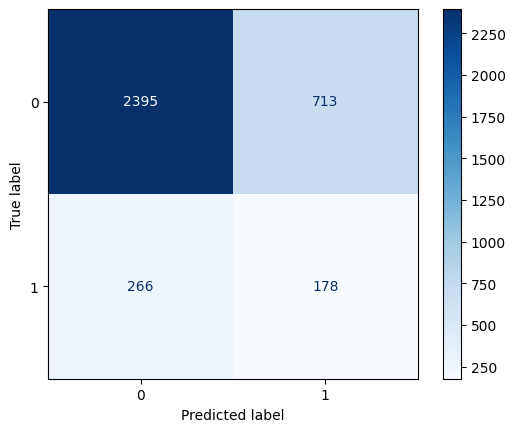

 
              precision    recall  f1-score   support

           0       0.90      0.77      0.83      3108
           1       0.20      0.40      0.27       444

    accuracy                           0.72      3552
   macro avg       0.55      0.59      0.55      3552
weighted avg       0.81      0.72      0.76      3552



In [ ]:
# GPTrelev
y_test = df_final['Diagnosed_YN']
y_pred = df_final['predict_GPTrelev']
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print(' ')
print(classification_report(y_test, y_pred))

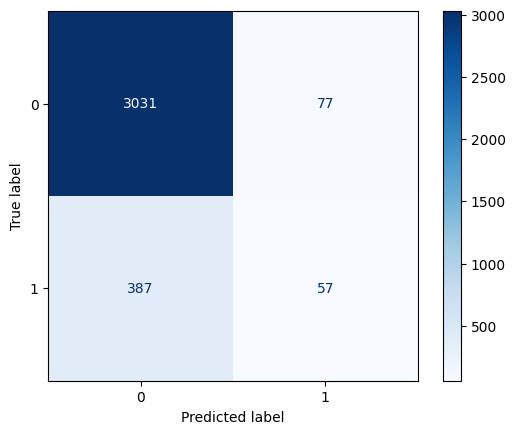

 
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      3108
           1       0.43      0.13      0.20       444

    accuracy                           0.87      3552
   macro avg       0.66      0.55      0.56      3552
weighted avg       0.83      0.87      0.84      3552



In [ ]:
# W2V.logreg
y_test = df_final['Diagnosed_YN']
y_pred = df_final['predict_w2vreglog']
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print(' ')
print(classification_report(y_test, y_pred))

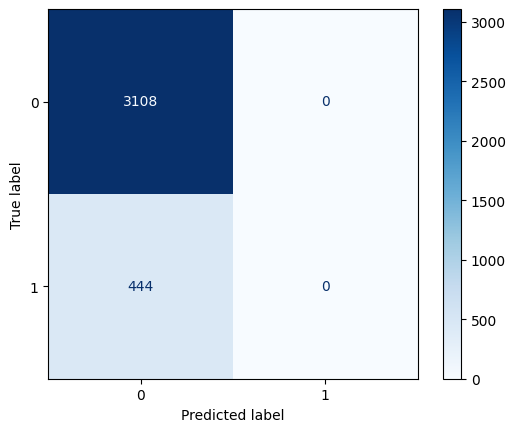

 
              precision    recall  f1-score   support

           0       0.88      1.00      0.93      3108
           1       0.00      0.00      0.00       444

    accuracy                           0.88      3552
   macro avg       0.44      0.50      0.47      3552
weighted avg       0.77      0.88      0.82      3552



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Soft.BERT
y_test = df_final['Diagnosed_YN']
y_pred = df_final['predict_softbert']
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print(' ')
print(classification_report(y_test, y_pred))

### Distribuição das notas

In [27]:
# Funções

# Substituição de texto por zero
def replace_phrases_with_zero(lst):
    new_lst = [0 if isinstance(item, str) and not item.isdigit() else int(item) for item in lst]
    return new_lst

# Obtenção da lista de notas
def escore_list(df):
  notas_list = list(chain.from_iterable(df['label_min']))
  notas_list_filtrada = [nota for nota in notas_list if nota not in (0, 1, 2)]

  # Contar a frequência dos valores
  contagens = Counter(notas_list_filtrada)

  # Criar um DataFrame a partir do dicionário
  df_contagens = pd.DataFrame(contagens.items(), columns=['notas', 'quantidade'])

  # Calcular o total de todas as quantidades
  total = df_contagens['quantidade'].sum()

  # Adicionar a coluna de percentual
  df_contagens['percentual'] = round((df_contagens['quantidade'] / total) * 100, 2)
  df_contagens.sort_values('notas', inplace=True)

  return df_contagens

# Obtenção da lista de notas
def escore_list_n_relev(df):
  notas_list = list(chain.from_iterable(df['label_min']))
  notas_list_filtrada = [nota for nota in notas_list if nota in (0, 1, 2)]

  # Contar a frequência dos valores
  contagens = Counter(notas_list_filtrada)

  # Criar um DataFrame a partir do dicionário
  df_contagens = pd.DataFrame(contagens.items(), columns=['notas', 'quantidade'])

  # Calcular o total de todas as quantidades
  total = df_contagens['quantidade'].sum()

  # Adicionar a coluna de percentual
  df_contagens['percentual'] = round((df_contagens['quantidade'] / total) * 100, 2)
  df_contagens.sort_values('notas', inplace=True)

  return df_contagens

# Obtenção da lista de notas
def escore_list_total(df):
  notas_list = list(chain.from_iterable(df['label_min']))

  # Contar a frequência dos valores
  contagens = Counter(notas_list)

  # Criar um DataFrame a partir do dicionário
  df_contagens = pd.DataFrame(contagens.items(), columns=['notas', 'quantidade'])

  # Calcular o total de todas as quantidades
  total = df_contagens['quantidade'].sum()

  # Adicionar a coluna de percentual
  df_contagens['percentual'] = round((df_contagens['quantidade'] / total) * 100, 2)
  df_contagens.sort_values('notas', inplace=True)

  return df_contagens

In [23]:
df_final['label_min'] = df_final['label_min'].apply(replace_phrases_with_zero)

# Dataframes de erros e acertos
df_final_erros = df_final[(df_final['Erro_GPTrelev'] == 1)]
df_final_acertos = df_final[(df_final['Erro_GPTrelev'] == 0)]

# Serparação nas classes positiva e negativa
df_final_erros_positiva = df_final_erros[df_final_erros['predict_GPTrelev'] == 1]
df_final_erros_negativa = df_final_erros[df_final_erros['predict_GPTrelev'] == 0]

df_final_acertos_positiva = df_final_acertos[df_final_acertos['predict_GPTrelev'] == 1]
df_final_acertos_negativa = df_final_acertos[df_final_acertos['predict_GPTrelev'] == 0]

print('Acertos da classe positiva')
df_escores_acertos_positiva = escore_list(df_final_acertos_positiva)
print(df_escores_acertos_positiva)
relevantes_acertos_positiva = df_escores_acertos_positiva['quantidade'].sum()
print(f'Quantidade de mensagens relevantes: {relevantes_acertos_positiva}')

print('##############################')

print('Acertos da classe negativa')
df_escores_acertos_negativa = escore_list(df_final_acertos_negativa)
print(df_escores_acertos_negativa)
relevantes_acertos_negativa = df_escores_acertos_negativa['quantidade'].sum()
print(f'Quantidade de mensagens relevantes: {relevantes_acertos_negativa}')

print('##############################')

print('Erros da classe positiva')
df_escores_erros_positiva = escore_list(df_final_erros_positiva)
print(df_escores_erros_positiva)
relevantes_erros_positiva = df_escores_erros_positiva['quantidade'].sum()
print(f'Quantidade de mensagens relevantes: {relevantes_erros_positiva}')

print('##############################')

print('Erros da classe negativa')
df_escores_erros_negativa = escore_list(df_final_erros_negativa)
print(df_escores_erros_negativa)
relevantes_erros_negativa = df_escores_erros_negativa['quantidade'].sum()
print(f'Quantidade de mensagens relevantes: {relevantes_erros_negativa}')

Acertos da classe positiva
   notas  quantidade  percentual
0      3        2714       46.20
3      4          61        1.04
4      5           2        0.03
1      6        2797       47.61
2      7         259        4.41
5      8          42        0.71
Quantidade de mensagens relevantes: 5875
##############################
Acertos da classe negativa
   notas  quantidade  percentual
0      3       23934       60.53
3      4         405        1.02
5      5           4        0.01
1      6       14401       36.42
2      7         708        1.79
4      8          87        0.22
Quantidade de mensagens relevantes: 39539
##############################
Erros da classe positiva
   notas  quantidade  percentual
1      3       10740       49.42
0      4         253        1.16
5      5           2        0.01
2      6        9880       45.46
3      7         781        3.59
4      8          76        0.35
Quantidade de mensagens relevantes: 21732
##############################
Erros da c

In [25]:
df_final['label_min'] = df_final['label_min'].apply(replace_phrases_with_zero)

# Dataframes de erros e acertos
df_final_erros = df_final[(df_final['Erro_GPTrelev'] == 1)]
df_final_acertos = df_final[(df_final['Erro_GPTrelev'] == 0)]

# Serparação nas classes positiva e negativa
df_final_erros_positiva = df_final_erros[df_final_erros['predict_GPTrelev'] == 1]
df_final_erros_negativa = df_final_erros[df_final_erros['predict_GPTrelev'] == 0]

df_final_acertos_positiva = df_final_acertos[df_final_acertos['predict_GPTrelev'] == 1]
df_final_acertos_negativa = df_final_acertos[df_final_acertos['predict_GPTrelev'] == 0]

print('Acertos da classe positiva')
df_escores_acertos_positiva = escore_list_n_relev(df_final_acertos_positiva)
print(df_escores_acertos_positiva)
relevantes_acertos_positiva = df_escores_acertos_positiva['quantidade'].sum()
print(f'Quantidade de mensagens relevantes: {relevantes_acertos_positiva}')

print('##############################')

print('Acertos da classe negativa')
df_escores_acertos_negativa = escore_list_n_relev(df_final_acertos_negativa)
print(df_escores_acertos_negativa)
relevantes_acertos_negativa = df_escores_acertos_negativa['quantidade'].sum()
print(f'Quantidade de mensagens relevantes: {relevantes_acertos_negativa}')

print('##############################')

print('Erros da classe positiva')
df_escores_erros_positiva = escore_list_n_relev(df_final_erros_positiva)
print(df_escores_erros_positiva)
relevantes_erros_positiva = df_escores_erros_positiva['quantidade'].sum()
print(f'Quantidade de mensagens relevantes: {relevantes_erros_positiva}')

print('##############################')

print('Erros da classe negativa')
df_escores_erros_negativa = escore_list_n_relev(df_final_erros_negativa)
print(df_escores_erros_negativa)
relevantes_erros_negativa = df_escores_erros_negativa['quantidade'].sum()
print(f'Quantidade de mensagens relevantes: {relevantes_erros_negativa}')

Acertos da classe positiva
   notas  quantidade  percentual
0      0        2295       23.03
1      1        2573       25.82
2      2        5099       51.16
Quantidade de mensagens relevantes: 9967
##############################
Acertos da classe negativa
   notas  quantidade  percentual
2      0       39982       23.03
1      1       53415       30.77
0      2       80219       46.20
Quantidade de mensagens relevantes: 173616
##############################
Erros da classe positiva
   notas  quantidade  percentual
1      0        7169       17.18
2      1       11178       26.79
0      2       23378       56.03
Quantidade de mensagens relevantes: 41725
##############################
Erros da classe negativa
   notas  quantidade  percentual
2      0        4868       26.43
1      1        5053       27.44
0      2        8495       46.13
Quantidade de mensagens relevantes: 18416


In [28]:
df_final['label_min'] = df_final['label_min'].apply(replace_phrases_with_zero)

# Dataframes de erros e acertos
df_final_erros = df_final[(df_final['Erro_GPTrelev'] == 1)]
df_final_acertos = df_final[(df_final['Erro_GPTrelev'] == 0)]

# Serparação nas classes positiva e negativa
df_final_erros_positiva = df_final_erros[df_final_erros['predict_GPTrelev'] == 1]
df_final_erros_negativa = df_final_erros[df_final_erros['predict_GPTrelev'] == 0]

df_final_acertos_positiva = df_final_acertos[df_final_acertos['predict_GPTrelev'] == 1]
df_final_acertos_negativa = df_final_acertos[df_final_acertos['predict_GPTrelev'] == 0]

print('Acertos da classe positiva')
df_escores_acertos_positiva = escore_list_total(df_final_acertos_positiva)
print(df_escores_acertos_positiva)
relevantes_acertos_positiva = df_escores_acertos_positiva['quantidade'].sum()
print(f'Quantidade de mensagens relevantes: {relevantes_acertos_positiva}')

print('##############################')

print('Acertos da classe negativa')
df_escores_acertos_negativa = escore_list_total(df_final_acertos_negativa)
print(df_escores_acertos_negativa)
relevantes_acertos_negativa = df_escores_acertos_negativa['quantidade'].sum()
print(f'Quantidade de mensagens relevantes: {relevantes_acertos_negativa}')

print('##############################')

print('Erros da classe positiva')
df_escores_erros_positiva = escore_list_total(df_final_erros_positiva)
print(df_escores_erros_positiva)
relevantes_erros_positiva = df_escores_erros_positiva['quantidade'].sum()
print(f'Quantidade de mensagens relevantes: {relevantes_erros_positiva}')

print('##############################')

print('Erros da classe negativa')
df_escores_erros_negativa = escore_list_total(df_final_erros_negativa)
print(df_escores_erros_negativa)
relevantes_erros_negativa = df_escores_erros_negativa['quantidade'].sum()
print(f'Quantidade de mensagens relevantes: {relevantes_erros_negativa}')

Acertos da classe positiva
   notas  quantidade  percentual
2      0        2295       14.49
3      1        2573       16.24
4      2        5099       32.19
0      3        2714       17.13
6      4          61        0.39
7      5           2        0.01
1      6        2797       17.66
5      7         259        1.63
8      8          42        0.27
Quantidade de mensagens relevantes: 15842
##############################
Acertos da classe negativa
   notas  quantidade  percentual
4      0       39982       18.76
3      1       53415       25.06
0      2       80219       37.63
1      3       23934       11.23
6      4         405        0.19
8      5           4        0.00
2      6       14401        6.76
5      7         708        0.33
7      8          87        0.04
Quantidade de mensagens relevantes: 213155
##############################
Erros da classe positiva
   notas  quantidade  percentual
3      0        7169       11.30
4      1       11178       17.62
0      2       

### Elapsed

In [33]:
# Import e criação do dataframe para análise
df_elapsed = pd.read_excel('/content/drive/MyDrive/Mestrado/Dissertação/Experimentos/elapsed_times.xlsx', sheet_name='diagnosed_test_anxiety')


df_merged = pd.merge(df_final, df_elapsed, on='User_ID', how='left')
df_merged.head()

,User_ID,Diagnosed_YN,predict_w2vreglog,qtd_msgs_lidas_w2vreglog,predict_softbert,qtd_msgs_lidas_softbert,label_min,predict_GPTrelev,qtd_msgs_lidas_GPTrelev,Erro_w2vreglog,Erro_softbert,Erro_GPTrelev,Msg_Date,End,Elapsed,Old
0,A_1857,1,0,2133,0,2133,"[3, 6, 0, 0, 1, 1, 2, 1, 2, 1, 0, 2, 6, 6, 3, ...",1,74,1,1,0,28/10/2019,08/08/2019,81.0,0.0
1,A_1867,1,0,1081,0,1081,"[2, 2, 6, 2, 2, 3, 2, 3, 1, 3, 0, 2, 3, 0, 2, ...",0,89,1,1,1,17/03/2020,29/07/2019,232.0,1.0
2,A_414,1,0,1596,0,1596,"[1, 0, 1, 6, 2, 3, 0, 0, 6, 0, 1, 3, 2, 2, 6, ...",0,89,1,1,1,21/01/2021,18/01/2021,3.0,0.0
3,A_486,1,0,957,0,957,"[0, 1, 0, 0, 1, 1, 1, 1, 2, 0, 6, 1, 1, 1, 3, ...",0,89,1,1,1,24/12/2020,20/12/2020,4.0,0.0
4,A_644,1,0,103,0,103,"[1, 1, 2, 1, 1, 0, 3, 6, 2, 6, 1, 7, 0, 6, 3, ...",0,89,1,1,1,04/11/2020,02/11/2020,2.0,0.0


In [34]:
df_merged.pivot_table(index='Erro_GPTrelev', columns='Old', aggfunc='count', values='Diagnosed_YN')

Old,0.0,1.0
Erro_GPTrelev,,
0,145,33
1,224,42


### H1 - Timeline negativa apresenta indícios de ansiedade (Falsos positivos)

Distribuição de notas para os casos de erro

In [ ]:
def replace_phrases_with_zero(lst):
    new_lst = [0 if isinstance(item, str) and not item.isdigit() else int(item) for item in lst]
    return new_lst

df_final['label_min'] = df_final['label_min'].apply(replace_phrases_with_zero)

# Distribuição das notas nestas timelines
df_final_erros = df_final[(df_final['predict_GPTrelev'] == 1) & (df_final['Diagnosed_YN'] == 0) & (df_final['predict_w2vreglog'] == 0)]

In [ ]:
notas_list_erros = list(chain.from_iterable(df_final_erros['label_min']))
notas_list_erros_filtrada = [nota for nota in notas_list_erros if nota not in (0, 1, 2)]

# Contar a frequência dos valores
contagens_erros = Counter(notas_list_erros_filtrada)

# Criar um DataFrame a partir do dicionário
df_contagens_erros = pd.DataFrame(contagens_erros.items(), columns=['notas', 'quantidade'])

# Calcular o total de todas as quantidades
total = df_contagens_erros['quantidade'].sum()

# Adicionar a coluna de percentual
df_contagens_erros['percentual'] = round((df_contagens_erros['quantidade'] / total) * 100, 2)
df_contagens_erros.sort_values('notas')

,notas,quantidade,percentual
1,3,10009,49.74
0,4,237,1.18
5,5,2,0.01
2,6,9093,45.19
3,7,717,3.56
4,8,65,0.32


In [ ]:
# Média geral
round(sum(notas_list_erros_filtrada)/len(notas_list_erros_filtrada), 2)

4.53

Distribuição de notas para a classe positiva

In [ ]:
df_final_positivo = df_final[df_final['Diagnosed_YN'] == 1]

notas_list_pos = list(chain.from_iterable(df_final_positivo['label_min']))
notas_list_pos_filtrada = [nota for nota in notas_list_pos if nota not in (0, 1, 2)]

# Contar a frequência dos valores
contagens_pos = Counter(notas_list_pos_filtrada)

# Criar um DataFrame a partir do dicionário
df_contagens_pos = pd.DataFrame(contagens_pos.items(), columns=['notas', 'quantidade'])

# Calcular o total de todas as quantidades
total = df_contagens_pos['quantidade'].sum()

# Adicionar a coluna de percentual
df_contagens_pos['percentual'] = round((df_contagens_pos['quantidade'] / total) * 100, 2)
df_contagens_pos.sort_values('notas')

,notas,quantidade,percentual
0,3,5814,52.22
3,4,112,1.01
4,5,2,0.02
1,6,4774,42.88
2,7,377,3.39
5,8,54,0.49


In [ ]:
# Média geral
round(sum(notas_list_pos_filtrada)/len(notas_list_pos_filtrada), 2)

4.31

### H2 - Distribuição de notas para a matriz de confusão

In [ ]:
df_final_TP = df_final[(df_final['predict_GPTrelev'] == 1) & (df_final['Diagnosed_YN'] == 1)]
df_final_TN = df_final[(df_final['predict_GPTrelev'] == 0) & (df_final['Diagnosed_YN'] == 0)]
df_final_FP = df_final[(df_final['predict_GPTrelev'] == 1) & (df_final['Diagnosed_YN'] == 0)]
df_final_FN = df_final[(df_final['predict_GPTrelev'] == 0) & (df_final['Diagnosed_YN'] == 1)]

In [ ]:
dataframe_list = ['TP', 'TN', 'FP', 'FN']

In [ ]:
for i in dataframe_list:
  print(i)
  notas_list = list(chain.from_iterable(globals()[f'df_final_{i}']['label_min']))

  # Contar a frequência dos valores
  contagens = Counter(notas_list)

  # Criar um DataFrame a partir do dicionário
  globals()[f'df_contagens_{i}'] = pd.DataFrame(contagens.items(), columns=['notas', 'quantidade'])

  # Calcular o total de todas as quantidades
  total = globals()[f'df_contagens_{i}']['quantidade'].sum()

  # Adicionar a coluna de percentual
  globals()[f'df_contagens_{i}']['percentual'] = round((globals()[f'df_contagens_{i}']['quantidade'] / total) * 100, 2)
  print(globals()[f'df_contagens_{i}'].sort_values('notas'))
  print('--------------------------------------')

TP
   notas  quantidade  percentual
2      0        2295       14.49
3      1        2573       16.24
4      2        5099       32.19
0      3        2714       17.13
6      4          61        0.39
7      5           2        0.01
1      6        2797       17.66
5      7         259        1.63
8      8          42        0.27
--------------------------------------
TN
   notas  quantidade  percentual
4      0       39982       18.76
3      1       53415       25.06
0      2       80219       37.63
1      3       23934       11.23
6      4         405        0.19
8      5           4        0.00
2      6       14401        6.76
5      7         708        0.33
7      8          87        0.04
--------------------------------------
FP
   notas  quantidade  percentual
3      0        7169       11.30
4      1       11178       17.62
0      2       23378       36.84
2      3       10740       16.92
1      4         253        0.40
8      5           2        0.00
5      6        9880  

### H3 - Timeline positiva não apresenta indícios de ansiedade (Falsos negativos)

Distribuição de notas para os casos de erro

In [ ]:
def replace_phrases_with_zero(lst):
    new_lst = [0 if isinstance(item, str) and not item.isdigit() else int(item) for item in lst]
    return new_lst

df_final['label_min'] = df_final['label_min'].apply(replace_phrases_with_zero)

# Distribuição das notas nestas timelines
df_final_erros = df_final[(df_final['predict_GPTrelev'] == 0) & (df_final['Diagnosed_YN'] == 1) & (df_final['predict_w2vreglog'] == 1)]

In [ ]:
notas_list_erros = list(chain.from_iterable(df_final_erros['label_min']))
notas_list_erros_filtrada = [nota for nota in notas_list_erros if nota not in (0, 1, 2)]

# Contar a frequência dos valores
contagens_erros = Counter(notas_list_erros_filtrada)

# Criar um DataFrame a partir do dicionário
df_contagens_erros = pd.DataFrame(contagens_erros.items(), columns=['notas', 'quantidade'])

# Calcular o total de todas as quantidades
total = df_contagens_erros['quantidade'].sum()

# Adicionar a coluna de percentual
df_contagens_erros['percentual'] = round((df_contagens_erros['quantidade'] / total) * 100, 2)
df_contagens_erros.sort_values('notas')

,notas,quantidade,percentual
3,3,259,56.67
2,4,6,1.31
0,6,174,38.07
1,7,17,3.72
4,8,1,0.22


In [ ]:
# Média geral
round(sum(notas_list_erros_filtrada)/len(notas_list_erros_filtrada), 2)

4.32

Distribuição de notas para a classe negativa

In [ ]:
df_final_negativo = df_final[df_final['Diagnosed_YN'] == 0]

notas_list_pos = list(chain.from_iterable(df_final_negativo['label_min']))
notas_list_pos_filtrada = [nota for nota in notas_list_pos if nota not in (0, 1, 2)]

# Contar a frequência dos valores
contagens_pos = Counter(notas_list_pos_filtrada)

# Criar um DataFrame a partir do dicionário
df_contagens_pos = pd.DataFrame(contagens_pos.items(), columns=['notas', 'quantidade'])

# Calcular o total de todas as quantidades
total = df_contagens_pos['quantidade'].sum()

# Adicionar a coluna de percentual
df_contagens_pos['percentual'] = round((df_contagens_pos['quantidade'] / total) * 100, 2)
df_contagens_pos.sort_values('notas')

,notas,quantidade,percentual
0,3,34674,56.59
2,4,658,1.07
5,5,6,0.01
1,6,24281,39.63
3,7,1489,2.43
4,8,163,0.27


In [ ]:
# Média geral
round(sum(notas_list_pos_filtrada)/len(notas_list_pos_filtrada), 2)

4.31